In [1]:
#En este proyecto se implementa LSTM, un tipo de RNN para  diseñada para resolver el desvanecimiento del gradiente que afecta a las RNN tradicionales

print("Para este proyecto se utiliza el dataset us_births_2016_2021.csv, obtenido de la plataforma Kaggle desde https://www.kaggle.com/datasets/danbraswell/temporary-us-births")

Para este proyecto se utiliza el dataset us_births_2016_2021.csv, obtenido de la plataforma Kaggle desde https://www.kaggle.com/datasets/danbraswell/temporary-us-births


In [22]:
#Importamos las librerías

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#Cargamos el dataset
data = pd.read_csv('us_births_2016_2021.csv')

print("Se observa que el data set se compone de 9 columnas correspondientes a los nacimientos por año en diferentes estados de los Estados Unidos de América, tomando en consideración factores como la edad de la madre, su nivel de educación y el peso promedio del recien nacido")
print("Al tener el número de nacimientos por año entre 2016-2021, el modelo LSTM resulta apropiado ya que este permite modelar dependencias a largo plazo en secuencias temporales y mantener información relevante si así se desea")

#Para este caso particular vamos a limitarnos simplemente a comparar el año 2021

Se observa que el data set se compone de 9 columnas correspondientes a los nacimientos por año en diferentes estados de los Estados Unidos de América, tomando en consideración factores como la edad de la madre, su nivel de educación y el peso promedio del recien nacido
Al tener el número de nacimientos por año entre 2016-2021, el modelo LSTM resulta apropiado ya que este permite modelar dependencias a largo plazo en secuencias temporales y mantener información relevante si así se desea


In [3]:
#Vamos a comprobar si el dataset no tiene valores nulos
data.isnull().sum()
#No tenemos ningún valor nulo por lo que no es necesario realizar una limpieza de datos

,0
State,0
State Abbreviation,0
Year,0
Gender,0
Education Level of Mother,0
Education Level Code,0
Number of Births,0
Average Age of Mother (years),0
Average Birth Weight (g),0


In [4]:
#Ahora vamos a convertir los valores categóricos en numéricos para las columnas 'State', 'Gender', 'Education Level of Mother' y 'State Abbreviation'
data['State'] = pd.factorize(data['State'])[0]
data['Gender'] = pd.factorize(data['Gender'])[0]
data['Education Level of Mother'] = pd.factorize(data['Education Level of Mother'])[0]
data['State Abbreviation'] = pd.factorize(data['State Abbreviation'])[0]

Se observa que hay una correlación débil entre el número de nacimientos y el código de educación de la madre, siendo esta la mayor correlación que hay
Note también que variables como 'State Abreviation','Gender' y Aberage Birth Weight(g)' no son tan relevanta para la predicción a pesar de la correlación pues corresponden a factores posteriores al nacimiento y como tal no son causales


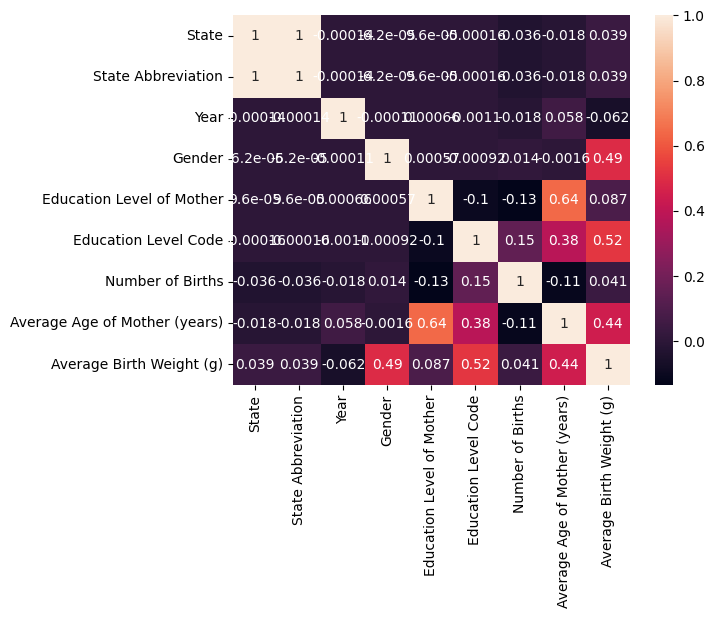

In [5]:
#Comprobemos la matriz de correlación para ver que variables nos ayudan a predecir mejor el número de nacimientos mediante un mapa de calor
import seaborn as sns
sns.heatmap(data.corr(), annot=True)
print("Se observa que hay una correlación débil entre el número de nacimientos y el código de educación de la madre, siendo esta la mayor correlación que hay")
print("Note también que variables como 'State Abreviation','Gender' y Aberage Birth Weight(g)' no son tan relevanta para la predicción a pesar de la correlación pues corresponden a factores posteriores al nacimiento y como tal no son causales")

In [6]:
#Seleccionamos solo las columnas que resultan relevantes
data = data[['Year', 'Average Age of Mother (years)', 'Education Level of Mother', 'Number of Births']]

In [12]:
#Cargar los datos de entrenamiento
#Vamos a utlizar el número de nacimientos de 2016 como entrenamiento para predecir el número de nacimientos en 2021, posteriormente lo vamos a comparar con el número real de nacimientos en 2021
train_data = data[data['Year'] == 2016] #Datos de entrenamiento
real_data = data[data['Year'] == 2021] #Datos reales para comparación

#Escalado de datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Average Age of Mother (years)', 'Education Level of Mother', 'Number of Births']])
real_scaled = scaler.transform(real_data[['Average Age of Mother (years)', 'Education Level of Mother', 'Number of Births']])

In [13]:
#Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(dataset, look_back=10):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back, :])
        Y.append(dataset[i + look_back, 2])  # índice 2 = Births
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled, 10)
X_test, y_test = create_dataset(real_scaled, 10)

In [14]:
#Modelo LSTM
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 100)             │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,101 (476.96 KB)

 Trainable params: 122,101 (476.96 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#Entrenar el modelo
history = model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0641
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0082
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0071
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0067
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0058
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0057
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0062
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0057
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026
Epoch 12/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0044
Epoch 13/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0026
Epoch 14/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026
Epoch 15/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018
Epoc

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


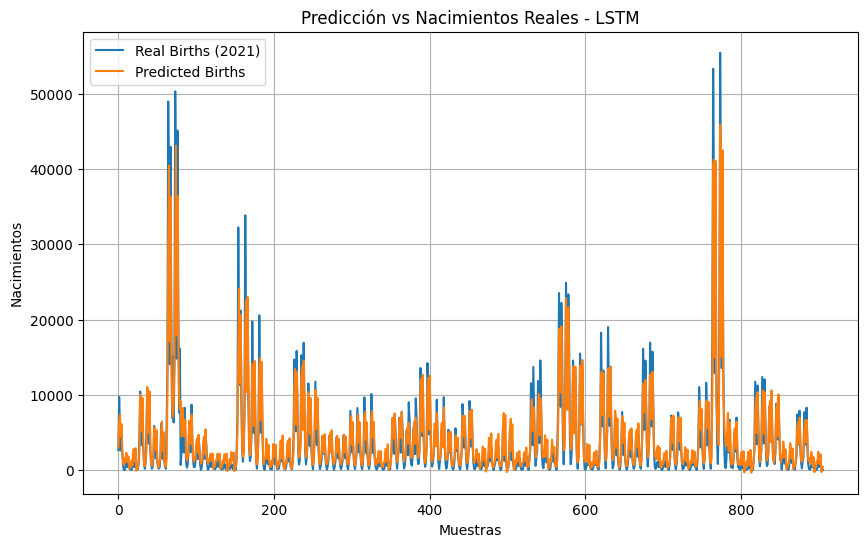

In [20]:
#Predicciones
y_pred = model.predict(X_test)

#Asegurar que y_pred e y_test sean 1D
y_pred_flat = y_pred[:, 0]
y_test_flat = y_test

#Inversión de escala
dummy_input = np.zeros((len(y_pred_flat), 3))
dummy_input[:, 2] = y_pred_flat
inverted_pred = scaler.inverse_transform(dummy_input)[:, 2]

dummy_input[:, 2] = y_test_flat
inverted_real = scaler.inverse_transform(dummy_input)[:, 2]

#Graficar
plt.figure(figsize=(10,6))
plt.plot(inverted_real, label='Real Births (2021)')
plt.plot(inverted_pred, label='Predicted Births')
plt.title('Predicción vs Nacimientos Reales - LSTM')
plt.xlabel('Muestras')
plt.ylabel('Nacimientos')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
#Ahora vamos a calcular el R-squared para comprobar que tanto se aleja la predicción de la realidad
from sklearn.metrics import r2_score

r2 = r2_score(inverted_real, inverted_pred)
print(f"R-squared: {r2}")
#Note que el valor de R-squared es de 0.89 por lo tanto es aceptable

R-squared: 0.8962437413490744
